# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

import seaborn as sns


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
#DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_1000Cases_H2_UncertanParams/')
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_2500Cases_H2_UncertanICsParams_Diff/')

#path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_1000Cases_H2_UncertanParams/MIONet/Run_2/')
path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_2500Cases_H2_UncertanICsParams_Diff/MIONet/Run_2/')

FigDir           = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


# DataType         = 'train'
# n_ics            = 100
# n_params         = 100
# #ics_vec          = [0,20,40,60,80,99]
# #k_vec            = [0,20,40,60,80,99]
# ics_vec          = [50]
# k_vec            = np.arange(100)

# DataType         = 'test'
# n_ics            = 1
# n_params         = 4
# ics_vec          = np.arange(n_ics)
# k_vec            = np.arange(n_params)

DataType         = 'PDF'
n_ics            = 1
n_params         = 636
ics_vec          = np.arange(n_ics)
k_vec            = np.arange(n_params)



NSamples         = 1

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/MIONet/../../../../../../ROMNet/0DReact_Isobaric_2500Cases_H2_UncertanICsParams_Diff/MIONet/Run_2/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - mionet.py               ]:   Constructing MIONet: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: MIONet
[ROMNet - component.py              ]:       Constructing Component: Branch1_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x1685bc700>, <keras.layers.core.dense.Dense object at 0x16855b640>, <keras.layers.core.dense.Dense object at 0x16855bd60>, <keras.layers.core.dense.Dense object at 0x16855be50>])
[ROMNet - component.py              ]:       Constructing Component: Branch2_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layer

## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [5]:
FileName     = DataDir + '/Orig/train/ext/y.csv.1'
Data         = pd.read_csv(FileName, header=0)
VarNames     = list(Data.columns)
VarNames.remove('t')

FileName     = DataDir + '/Orig/train/ext/CleanVars.csv'
Data         = pd.read_csv(FileName, header=0)
VarNamesAnti = list(Data.columns)

FileName     = DataDir + '/Orig/'+DataType+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()

In [6]:
ParamsDF = pd.read_csv(DataDir + '/Orig/'+DataType+'/ext/Perts.csv',header=None)
kNames   = ['$k_'+str(i+1)+'$' for i in range(ParamsDF.shape[1])]

ParamsDF.columns = kNames
ParamsDF.head(5)
Perts = ParamsDF.to_numpy()

In [7]:
ParamsDF

,$k_1$,$k_2$,$k_3$,$k_4$,$k_5$,$k_6$,$k_7$,$k_8$
0,-0.274025,-0.265318,-0.215330,0.164792,-0.416461,0.227972,0.111690,-0.436356
1,-0.173867,-0.430699,-0.071300,-0.304188,0.022864,-0.490230,-0.109433,-0.107086
2,-0.103501,-0.426861,-0.145228,-0.334203,-0.408847,-0.303924,-0.098772,-0.071728
3,-0.049610,-0.107310,0.036293,-0.295316,-0.352237,-0.269522,0.102491,-0.014372
4,-0.170899,-0.395216,-0.048405,-0.082957,-0.059963,-0.269199,-0.003187,-0.306814
...,...,...,...,...,...,...,...,...
631,0.167846,0.309853,0.432921,-0.043703,0.025152,-0.219895,0.266373,-0.263343
632,0.237658,0.277691,0.355321,0.122866,0.055396,-0.141892,0.339786,-0.080551
633,0.355831,0.349645,0.139166,-0.136858,0.106164,-0.208188,0.000558,-0.123658
634,0.301761,0.253185,0.144263,0.150172,-0.094972,0.068366,0.105223,0.111757


<AxesSubplot:xlabel='$k_1$', ylabel='Count'>

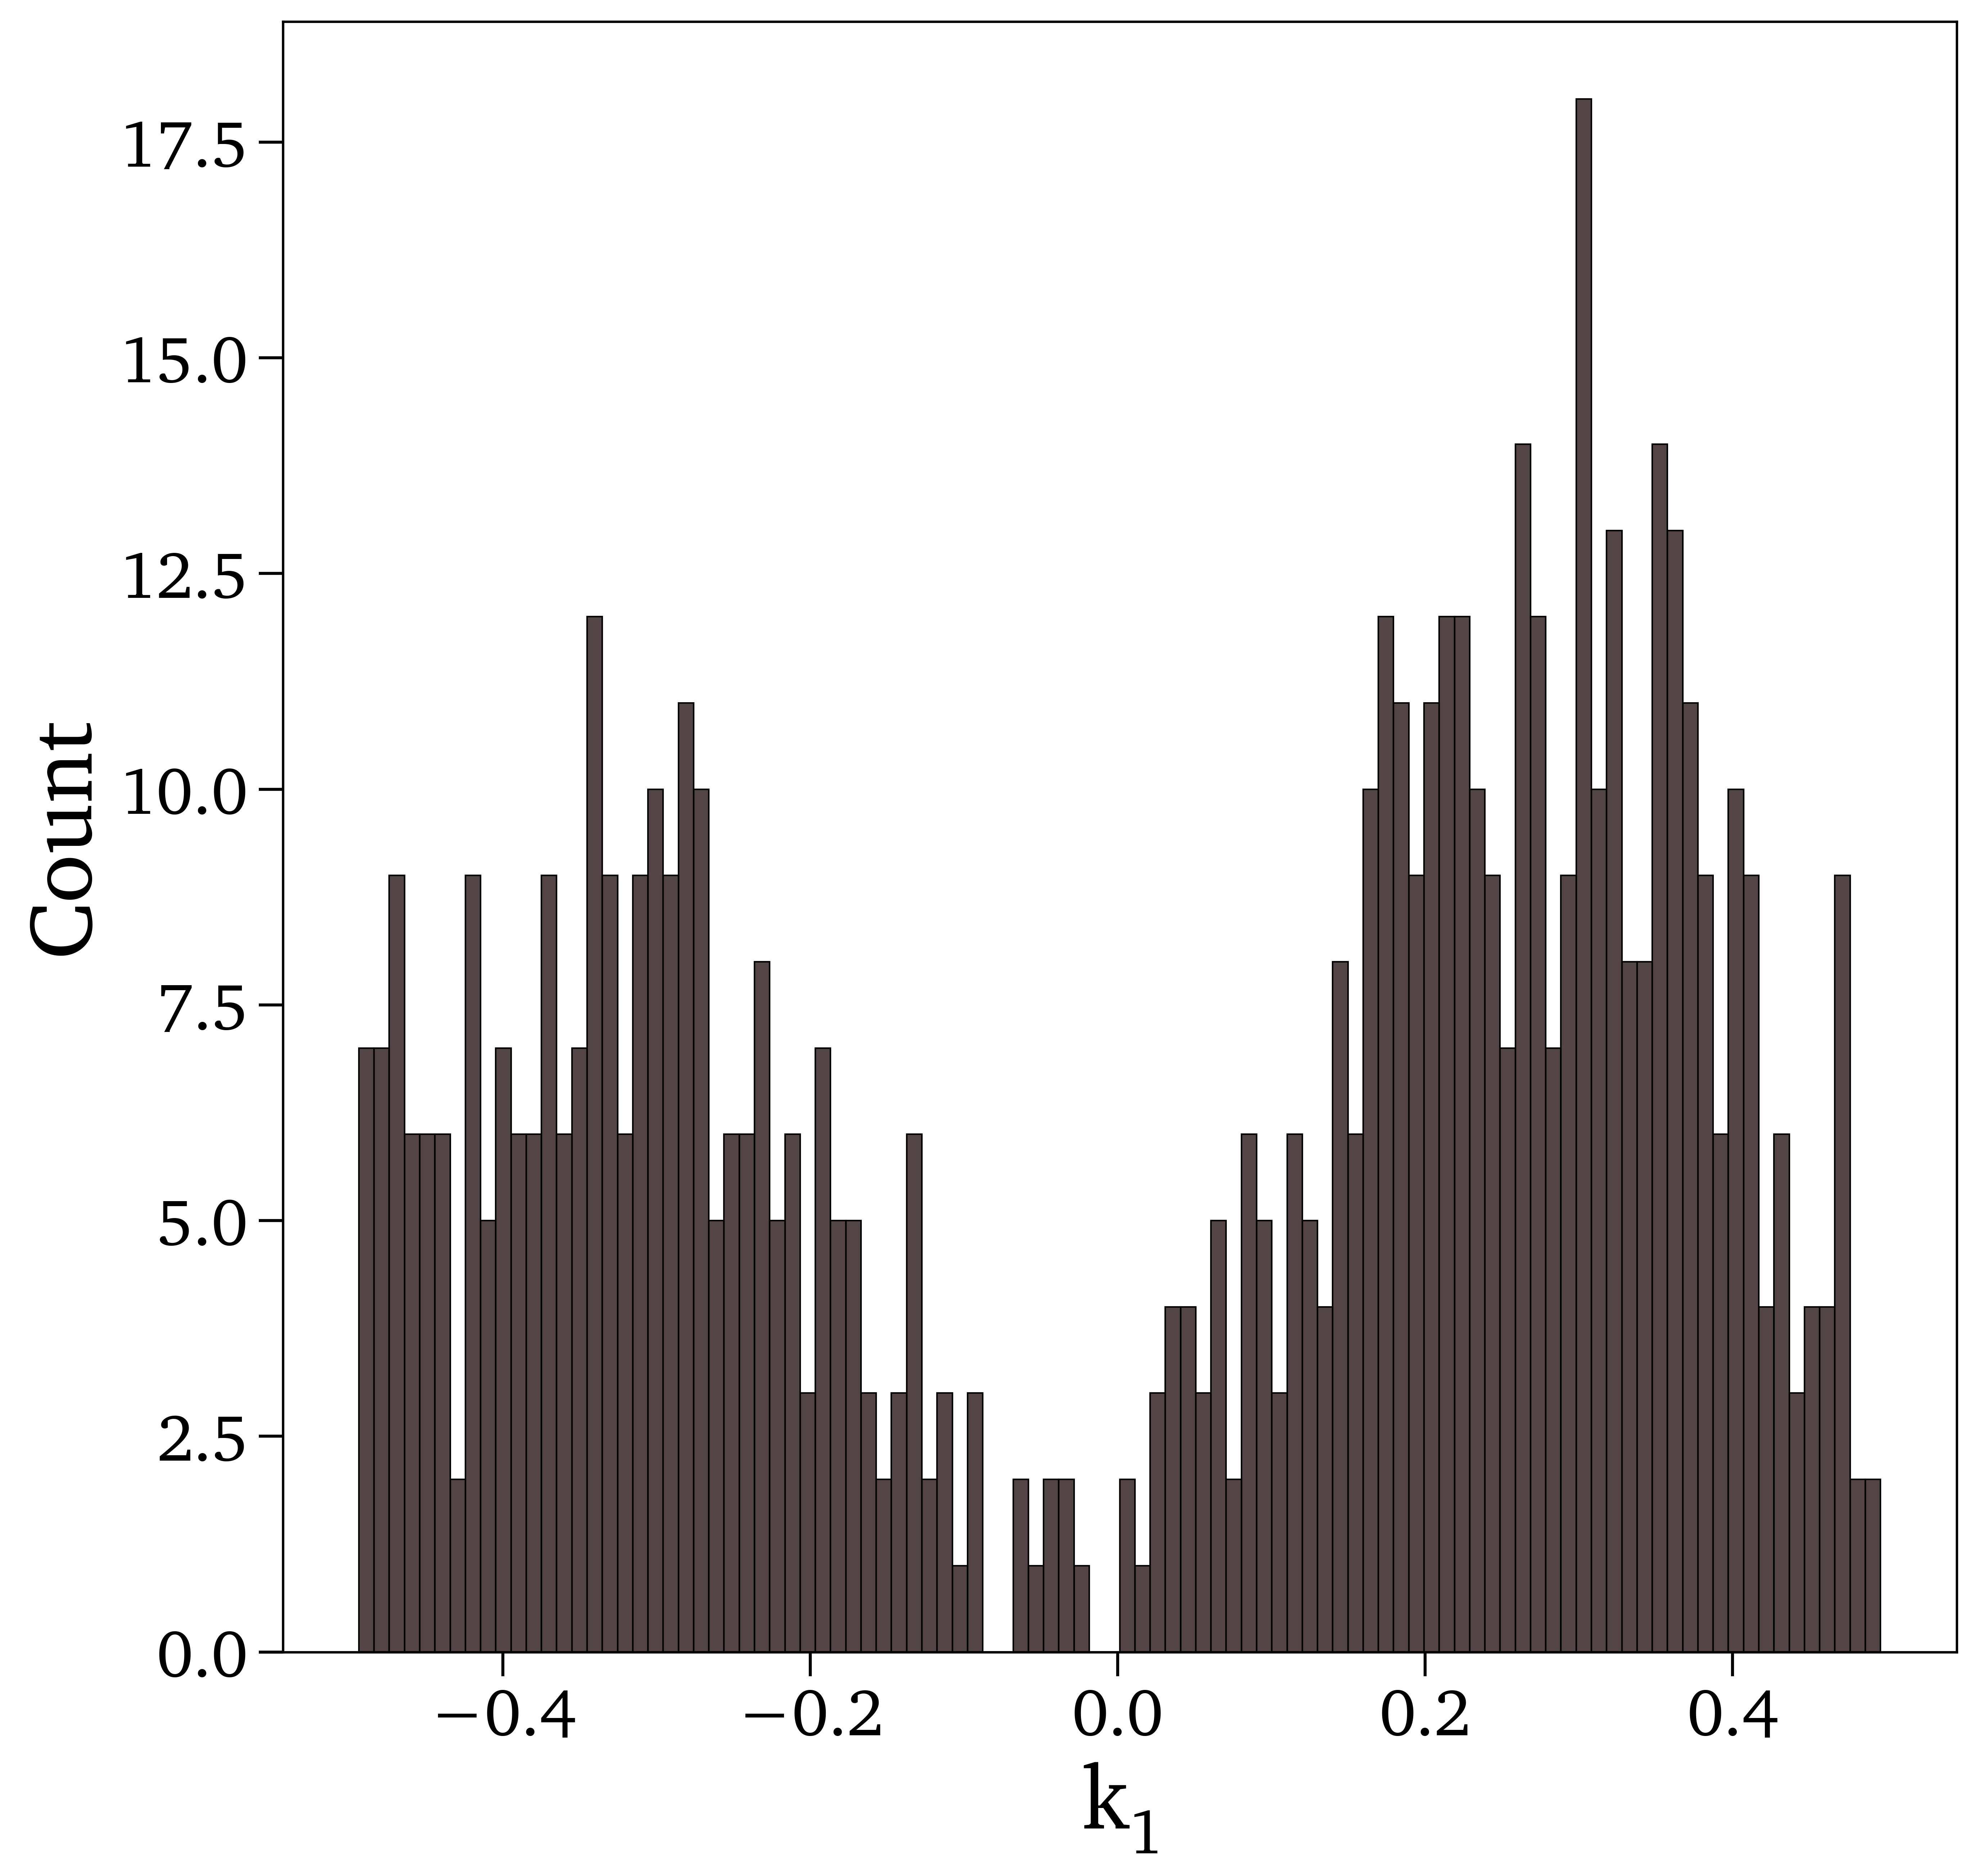

In [22]:
#sns.histplot(ParamsDF, x="$k_3$", y="$k_7$", bins=100)
sns.histplot(ParamsDF, x="$k_1$", bins=100)

### Loading Variables Info

In [9]:
Vars  = VarNamesAnti

Vars0 = []
for Var in Vars:
    Vars0.append(str(Var)+'0')
    
InputVars = Vars0 + kNames + ['t'] 

### Loading and Plotting Test/Training Data

In [10]:
# VarOI      = 'H'
# VarOI_Name = 'H'


# iVar     = Vars.index(VarOI)


# ax   = []
# fig  = []
# fig1 = plt.figure()
# fig.append(fig1)
# ax.append(plt.axes())

# MSE   = 0.

# iTest = 0
# for iIC in ics_vec:
#     for iK in k_vec:
#         # Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
#         # P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
#         # EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
#         # T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]

#         jTest = iIC * n_params + iK

#         #####################################################################################################
#         FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(jTest+1)
#         Data         = pd.read_csv(FileName, header=0)[['t']+Vars]
#         tVec0        = Data.to_numpy()[0,0]
#         tVec         = Data.to_numpy()[:,0] - tVec0
#         tVec[tVec == 0.] = FixedMinVal
#         y_Data       = Data[Vars].to_numpy()
#         #Data0        = Data[Data['t'] == 0.][Vars]
#         Nts          = len(Data)
#         print('T = ', Data['T'].to_numpy()[0], 'K')
#         #print(y_Data[0,:])

#         Data0            = pd.DataFrame([y_Data[0,:]], columns=Vars0)
#         Data0            = Data0.loc[Data0.index.repeat(Nts)]
#         Data0.columns    = Vars0
#         Data0.reset_index(drop=True, inplace=True)

#         ParamsTemp = ParamsDF.iloc[[iK]]
#         ParamsTemp = ParamsTemp.loc[ParamsTemp.index.repeat(Nts)]
#         ParamsTemp.reset_index(drop=True, inplace=True)
#         Data0      = pd.concat([Data0, ParamsTemp], axis=1)
#         #print(ParamsDF.iloc[[iK]])

#         Data0['t']       = tVec
#         Data0.reset_index(drop=True, inplace=True)

#         if (jTest == 0):
#             Label1 = 'ODE'
#             Label2 = 'PCA'
#             Label3 = 'DeepONet'
#             #Label3 = 'flexDeepONet'
#         else:
#             Label1 = ''
#             Label2 = ''
#             Label3 = ''

#         ax[0].plot(tVec+tVec0, y_Data[:,iVar],  '-', c=ColorVec[0], label=Label1)



#         y_Pred  = model.predict(Data0[InputVars])
#         ax[0].plot(tVec+tVec0, y_Pred[:,iVar], ':', c=ColorVec[1], label=Label3)

#     #     if (jTest == 0):   
#     #         MSE  = (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
#     #     else:
#     #         MSE += (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2

#         iTest += 1
    

# ax[0].set_xscale('log')
# ax[0].set_xlabel('Time [s]')
# if (VarOI == 'T'):
#     ax[0].set_ylabel('Temperature [K]')
# else:
#     ax[0].set_ylabel(r''+VarOI_Name+', Mass Fraction')
# ax[0].set_xlim([1.e-6,1.e-2])
# ax[0].legend()
    
    
# #MSE_ = MSE.sum(axis=0) / len(CasesVec) / (MSE.shape[0])
# # print('Mean Squared Error = ', MSE_)
    

# if (FigDir):
#     fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+VarOI+'.eps', format='eps', bbox_inches='tight')

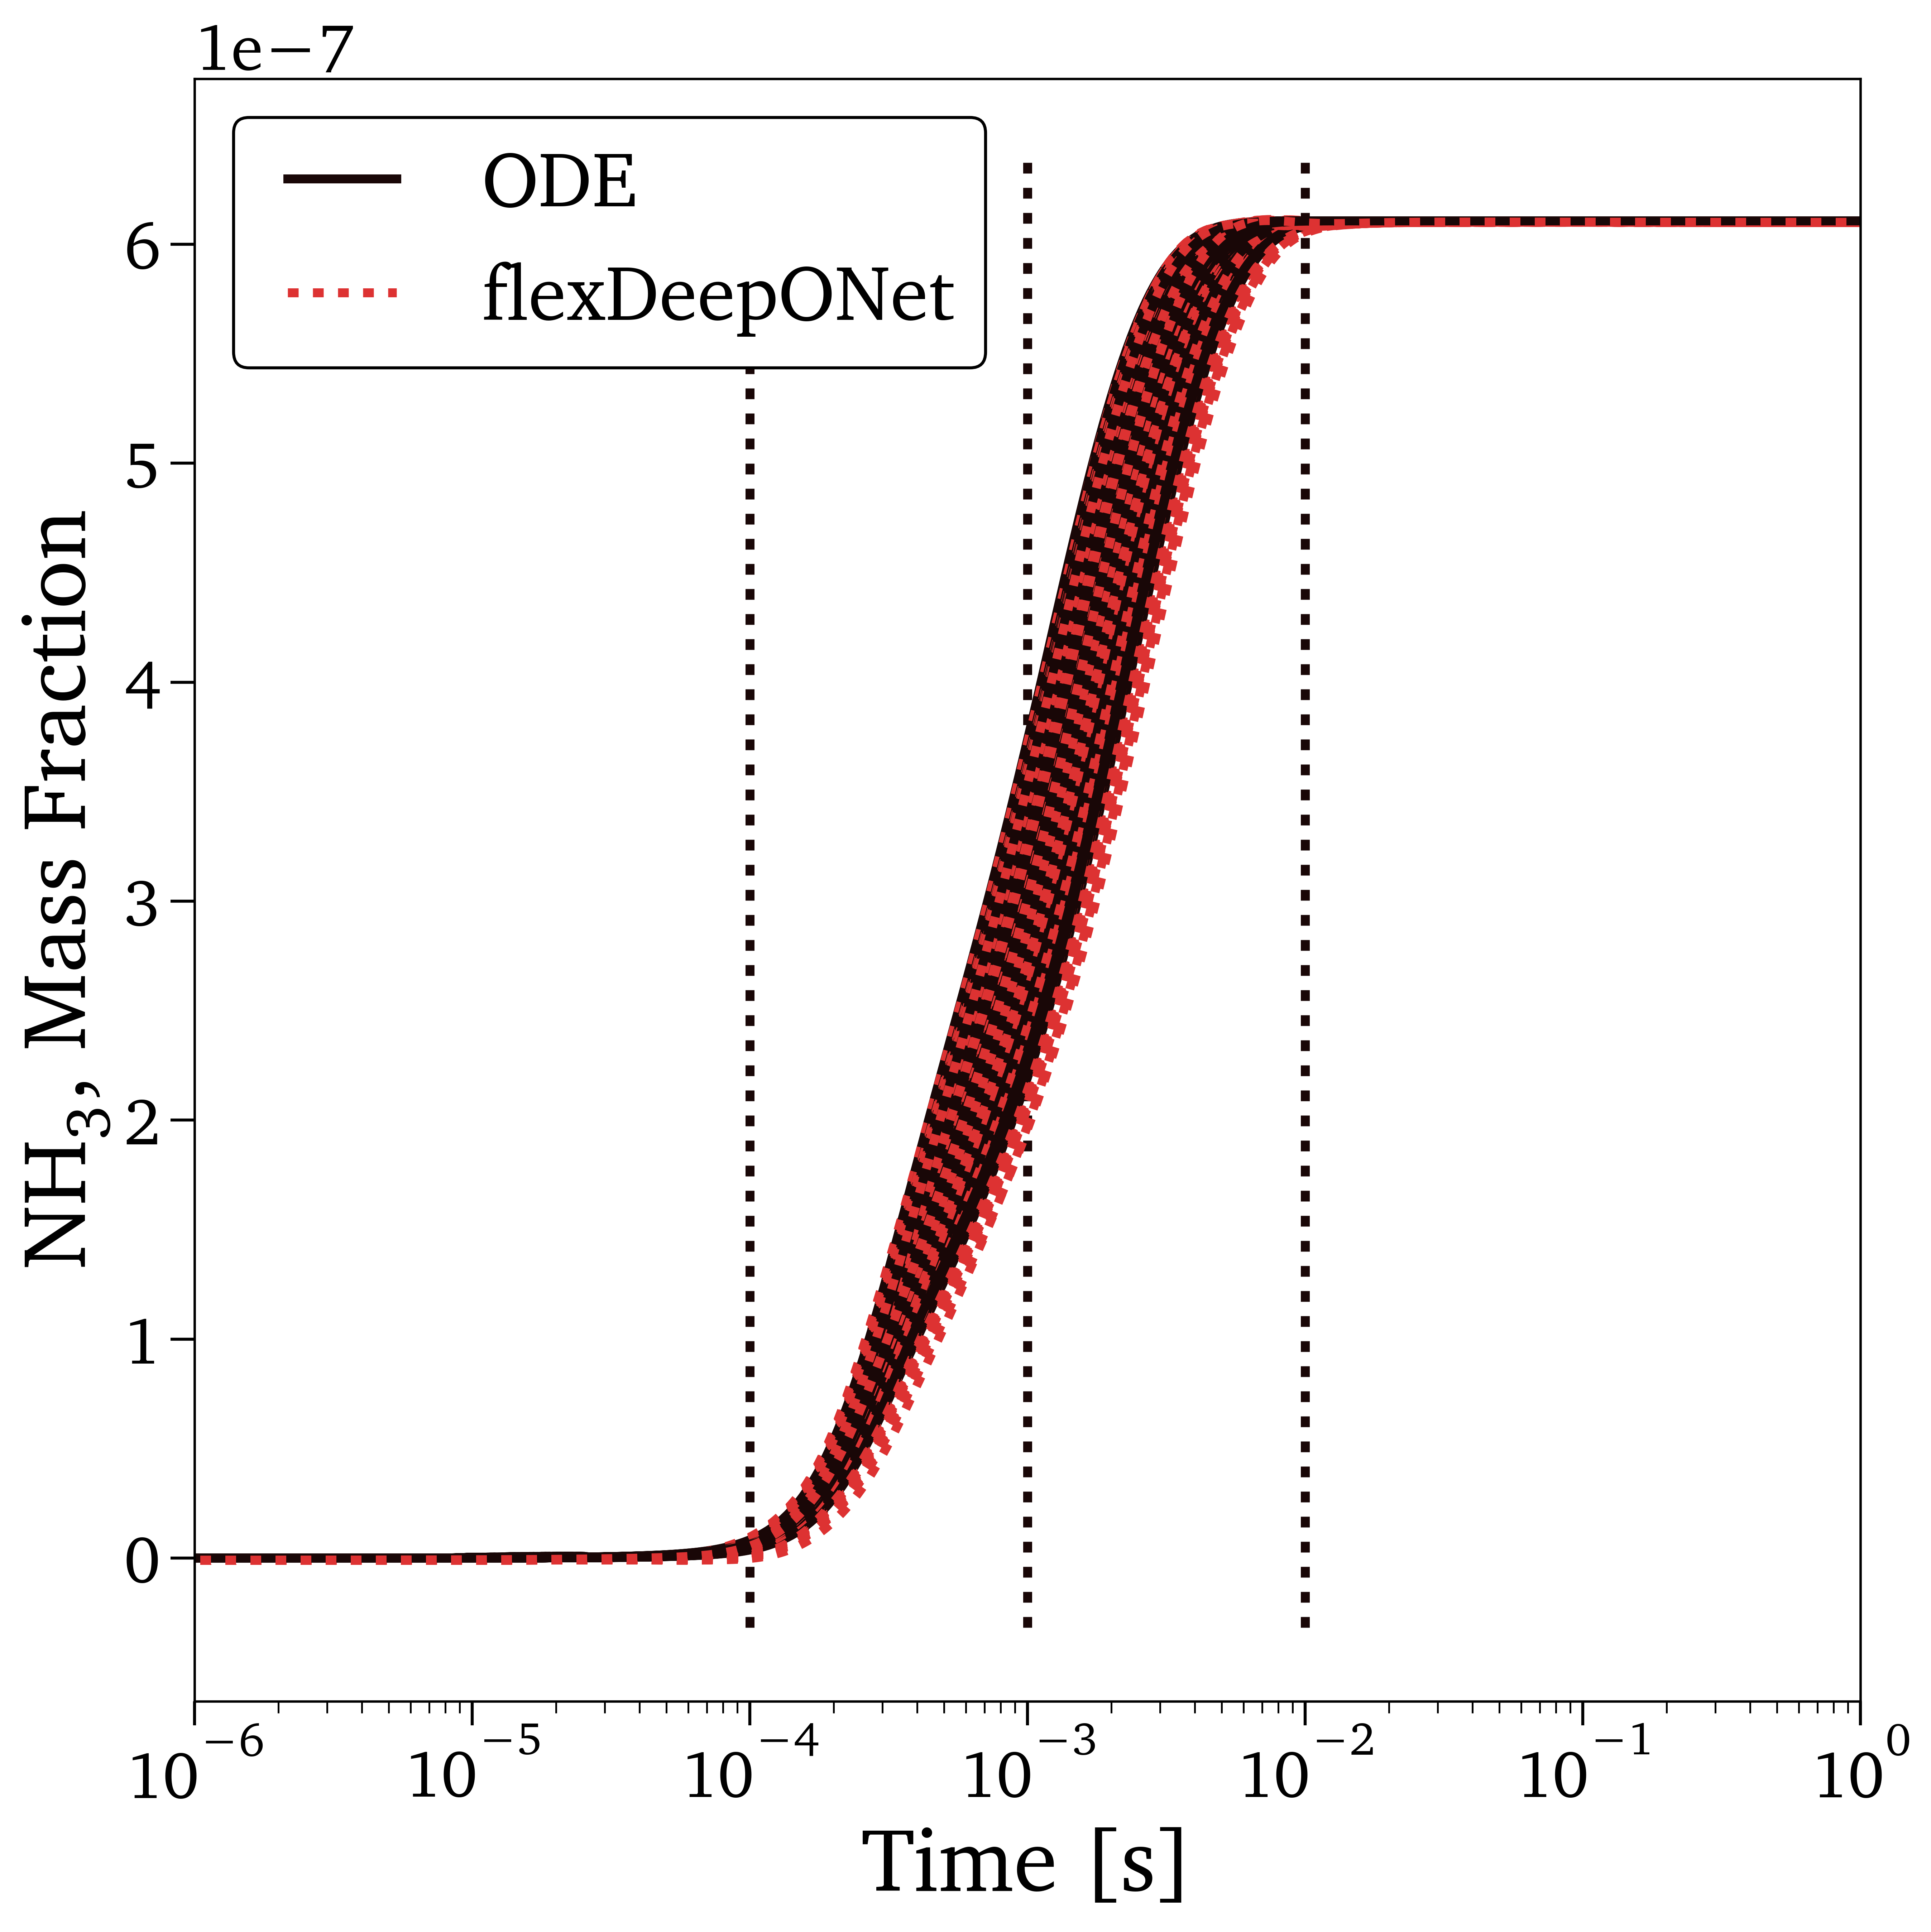

In [16]:
tVecHist   = np.array([1.e-4, 1.e-3, 1.e-2])
NtHist     = len(tVecHist)

# VarOI      = 'T'
# VarOI_Name = r'T'
VarOI      = 'NH3'
VarOI_Name = r'$NH_3$'


iVar     = Vars.index(VarOI)


ax   = []
fig  = []
fig1 = plt.figure()
fig.append(fig1)
ax.append(plt.axes())


NSamples_  = len(ics_vec)*len(k_vec)
yHist_Data = np.zeros((NSamples_,NtHist,len(Vars)))
yHist_Pred = np.zeros((NSamples_,NtHist,len(Vars)))
iTest      = 0
for iIC in ics_vec:
    for iK in k_vec:
        # Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
        # P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
        # EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
        # T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]

        jTest = iIC * n_params + iK

        #####################################################################################################
        FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(jTest+1)
        Data         = pd.read_csv(FileName, header=0)[['t']+Vars]
        tVec0        = Data.to_numpy()[0,0]
        tVec         = Data.to_numpy()[:,0] - tVec0
        tVec[tVec == 0.] = FixedMinVal
        y_Data       = Data[Vars].to_numpy()
        Nts          = len(Data)
        #print('T = ', Data['T'].to_numpy()[0], 'K')
        
        Data0            = pd.DataFrame([y_Data[0,:]], columns=Vars0)
        Data0            = Data0.loc[Data0.index.repeat(Nts)]
        Data0.columns    = Vars0
        Data0.reset_index(drop=True, inplace=True)

        ParamsTemp = ParamsDF.iloc[[iK]]
        ParamsTemp = ParamsTemp.loc[ParamsTemp.index.repeat(Nts)]
        ParamsTemp.reset_index(drop=True, inplace=True)
        Data0      = pd.concat([Data0, ParamsTemp], axis=1)
        
        i     = 0
        tMask = []
        for j, t_ in enumerate(tVec):
            if (t_ > tVecHist[i]):
                i += 1
                tMask.append(j)
                if (i == len(tVecHist)):
                    break
            

        Data0['t']       = tVec
        Data0.reset_index(drop=True, inplace=True)

        if (jTest == 0):
            Label1 = 'ODE'
            Label2 = 'PCA'
            Label3 = 'flexDeepONet'
            #Label3 = 'flexDeepONet'
        else:
            Label1 = ''
            Label2 = ''
            Label3 = ''

        ax[0].plot(tVec+tVec0, y_Data[:,iVar],  '-', c=ColorVec[0], label=Label1)
        yHist_Data[iTest,:,:] = y_Data[tMask,:]


        y_Pred  = model.predict(Data0[InputVars])
        ax[0].plot(tVec+tVec0, y_Pred[:,iVar], ':', c=ColorVec[1], label=Label3)
        yHist_Pred[iTest,:,:] = y_Pred[tMask,:]

        iTest += 1
    
yMin, yMax = ax[0].get_ylim()
ax[0].vlines(tVecHist, yMin, yMax, linestyles='dotted')
ax[0].set_xscale('log')
ax[0].set_xlabel('Time [s]')
if (VarOI == 'T'):
    ax[0].set_ylabel('Temperature [K]')
else:
    ax[0].set_ylabel(r''+VarOI_Name+', Mass Fraction')
ax[0].set_xlim([1.e-6,1.e0])
ax[0].legend()
    

if (FigDir):
    fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+VarOI+'.eps', format='eps', bbox_inches='tight')

[Text(0.5, 0, '$NH_3$')]

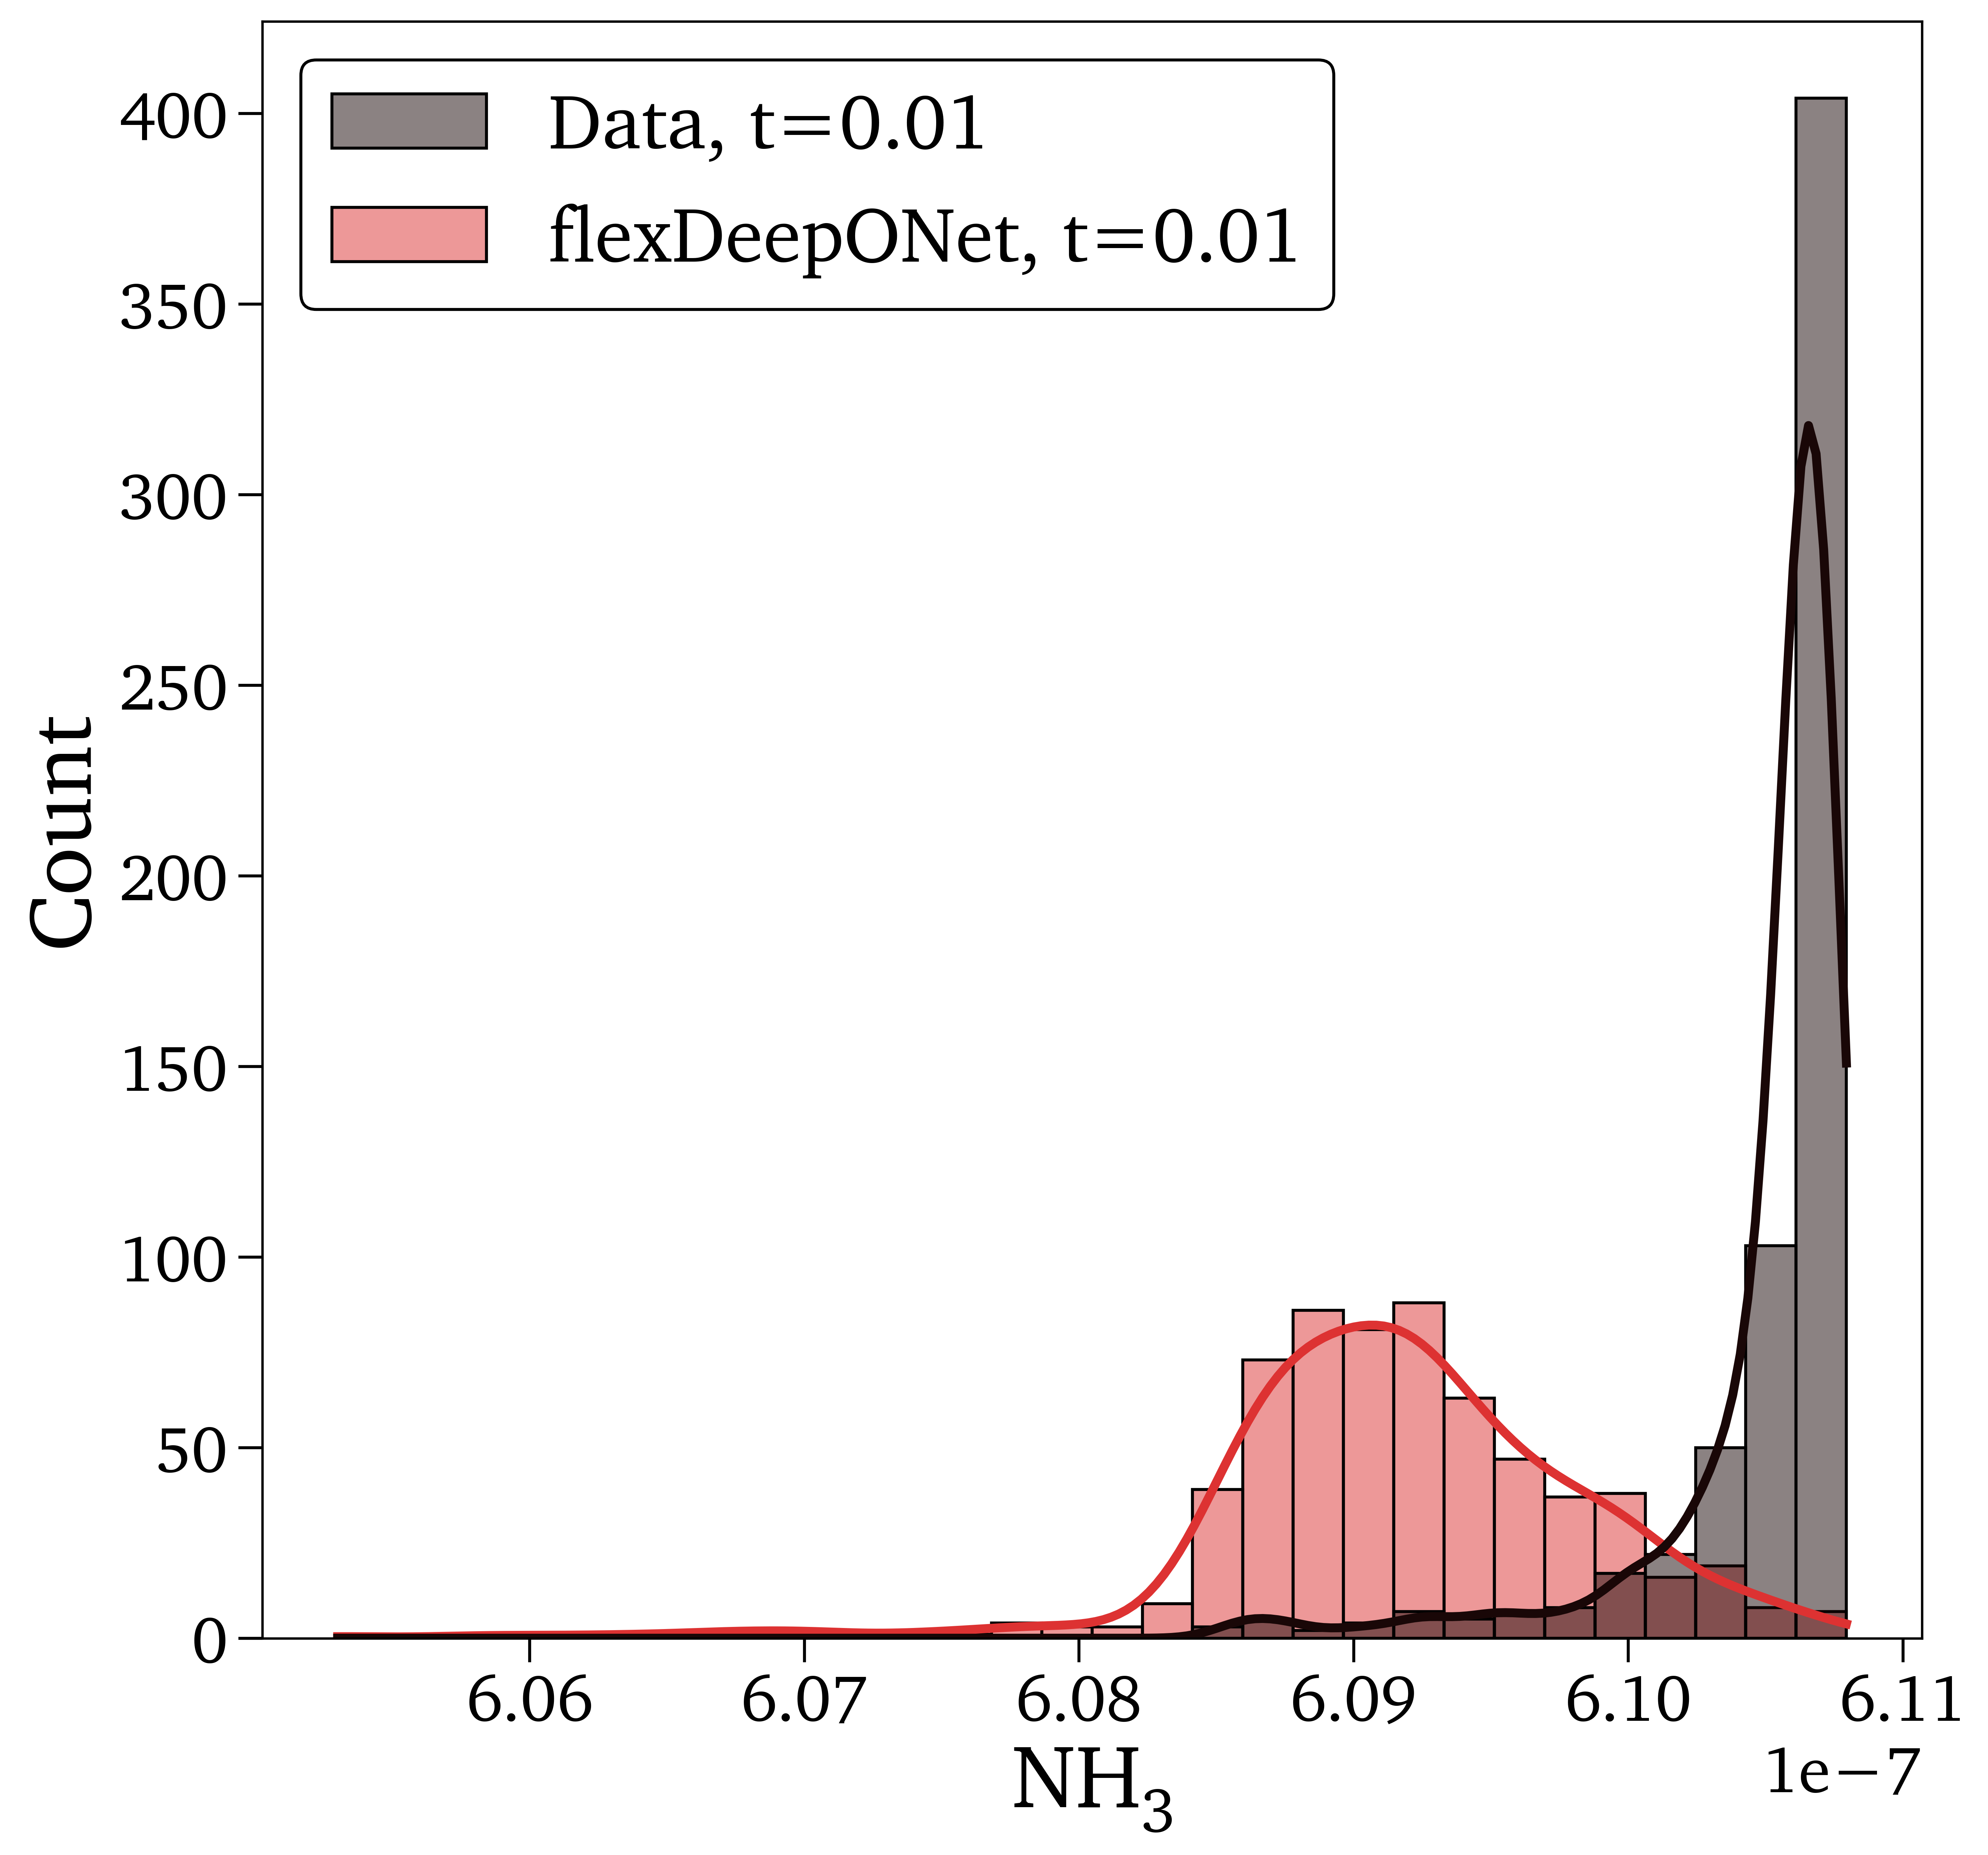

In [19]:
#VarOI      = 'T'
#VarOI_Name = 'Temperature [K]'
# VarOI      = 'NH3'
# VarOI_Name = r'$NH_3$'

itPlot     = [2] #range(NtHist)


iVar= Vars.index(VarOI)

DF1 = pd.DataFrame(yHist_Data[:,itPlot,iVar], columns=['Data, t='+str(tVecHist[i]) for i in itPlot])
DF2 = pd.DataFrame(yHist_Pred[:,itPlot,iVar], columns=['flexDeepONet, t='+str(tVecHist[i]) for i in itPlot])
DF  = pd.concat([DF1, DF2], axis=1)

ax  = sns.histplot(data=DF, bins=30, kde=True)#, log_scale=True)
ax.set(xlabel=VarOI_Name)

In [13]:
stop

NameError: name 'stop' is not defined

## Plotting Loss Histories

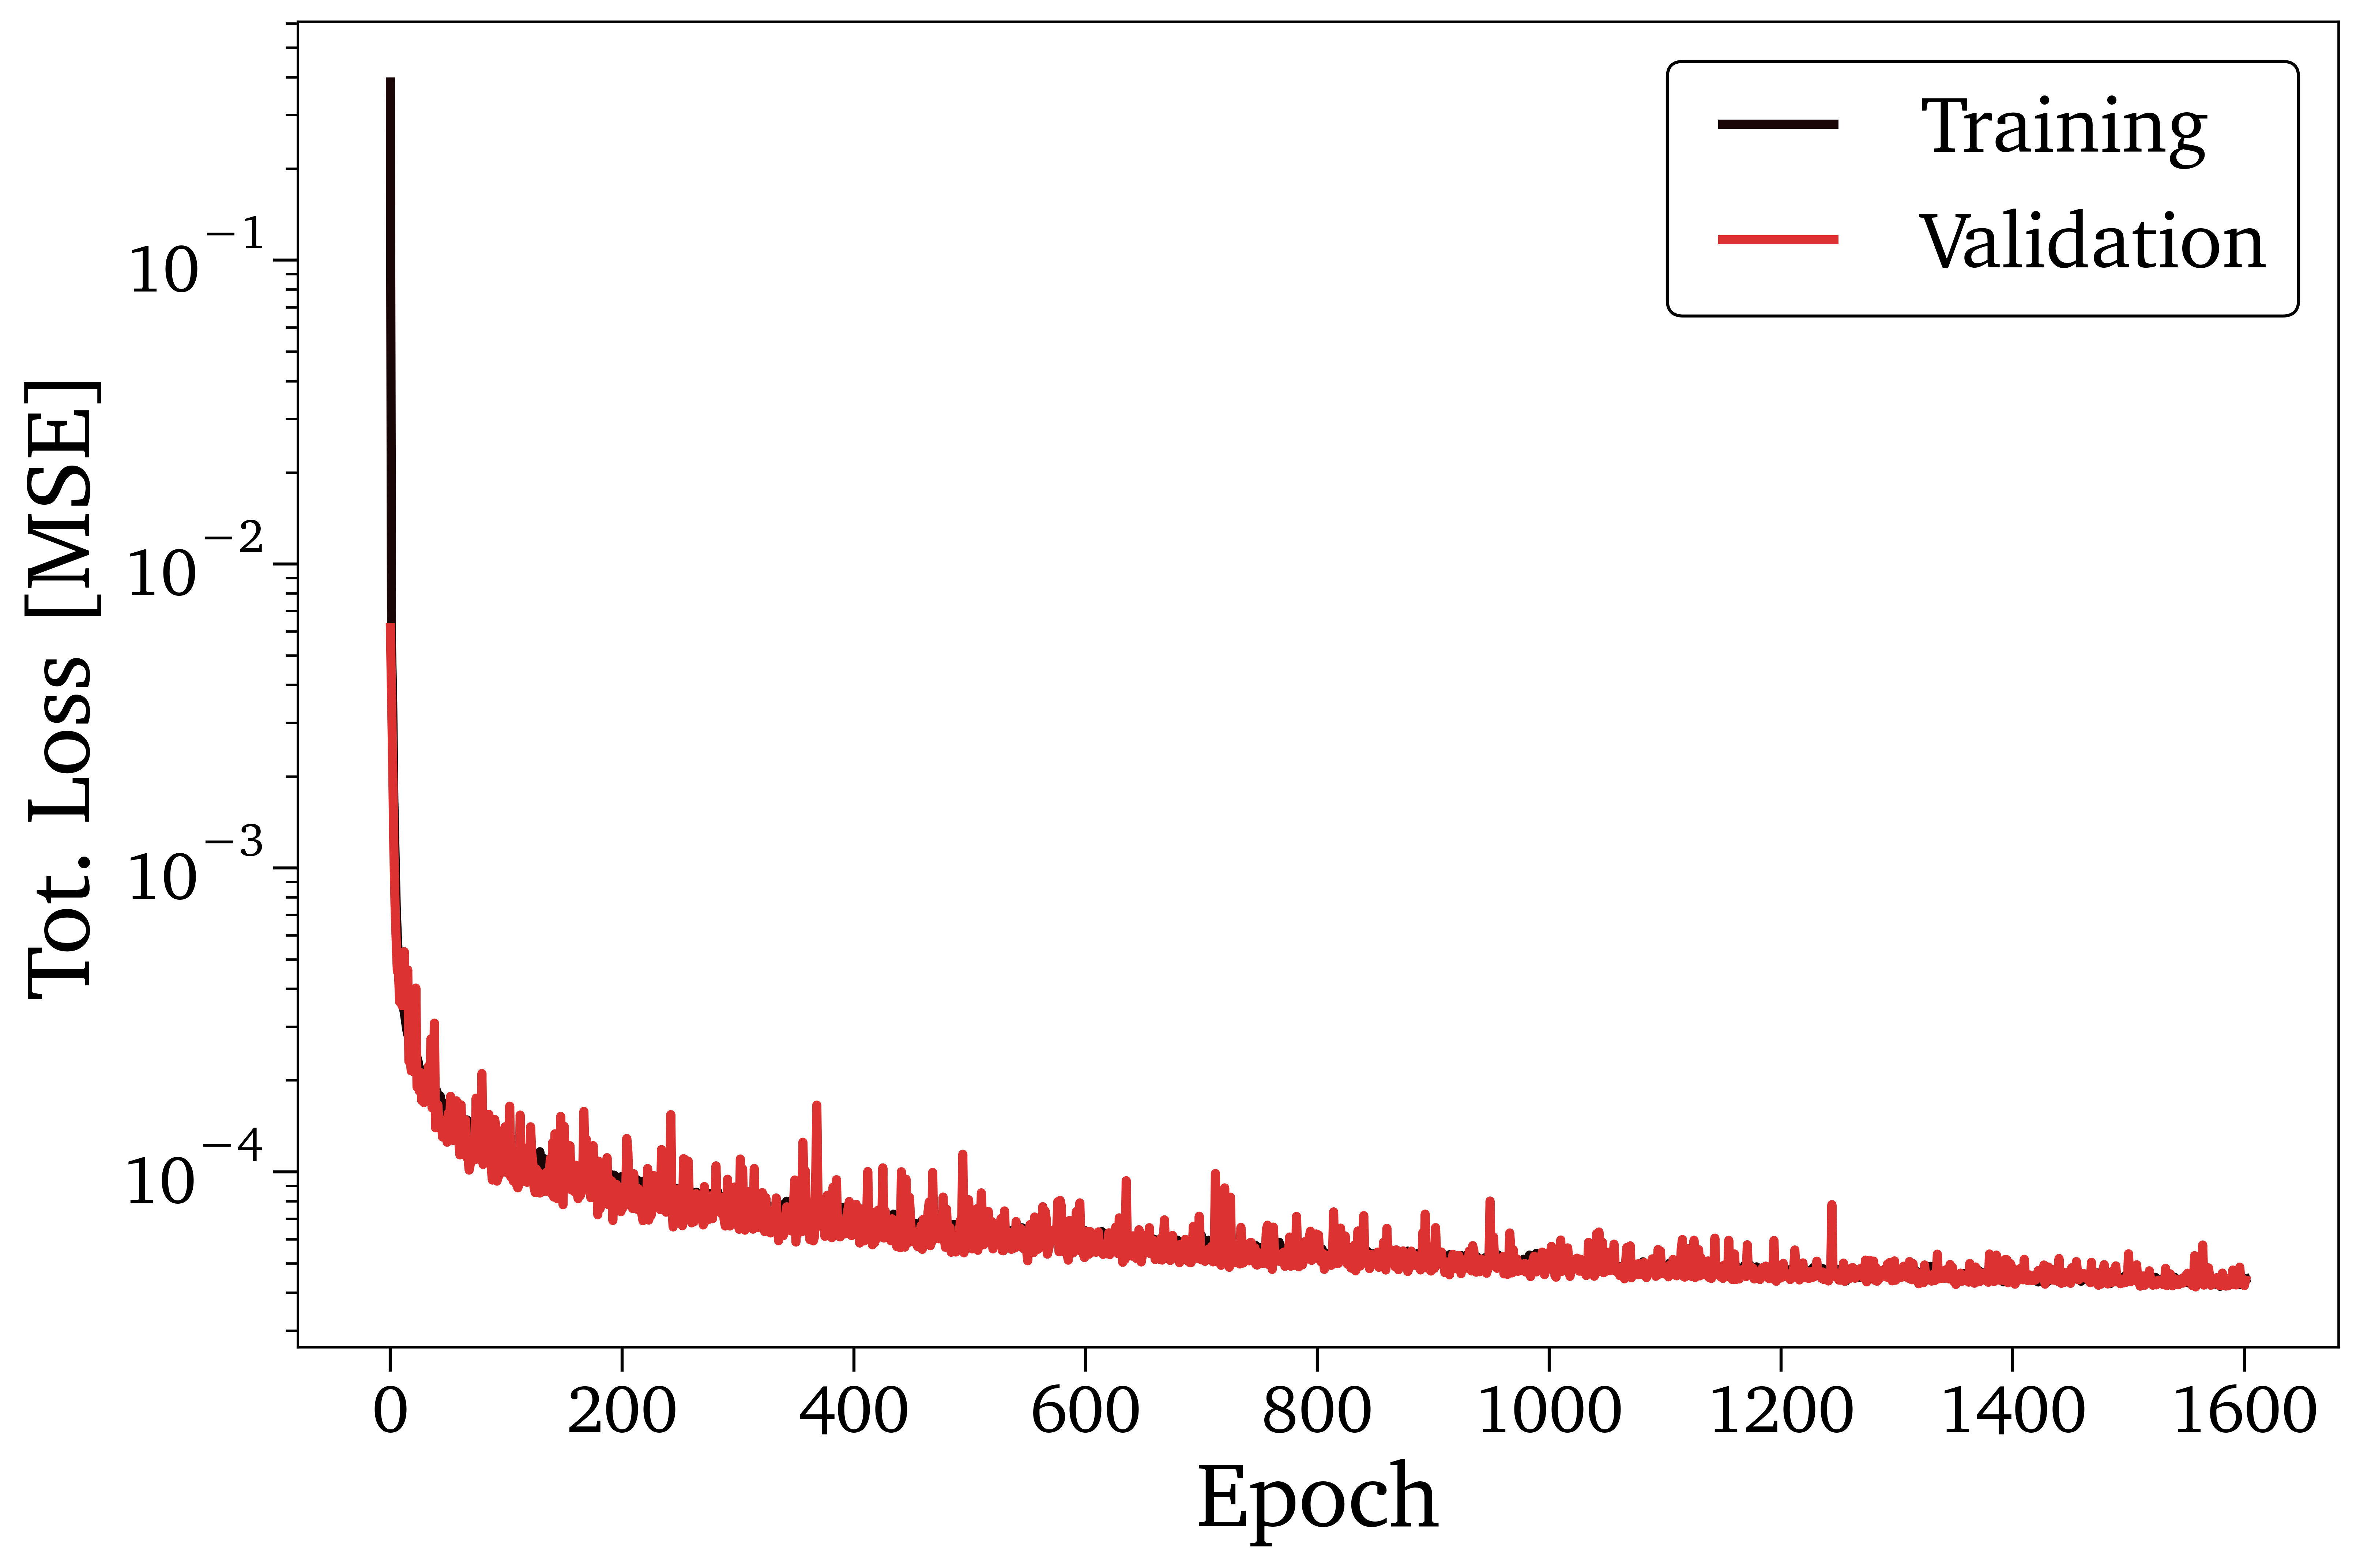

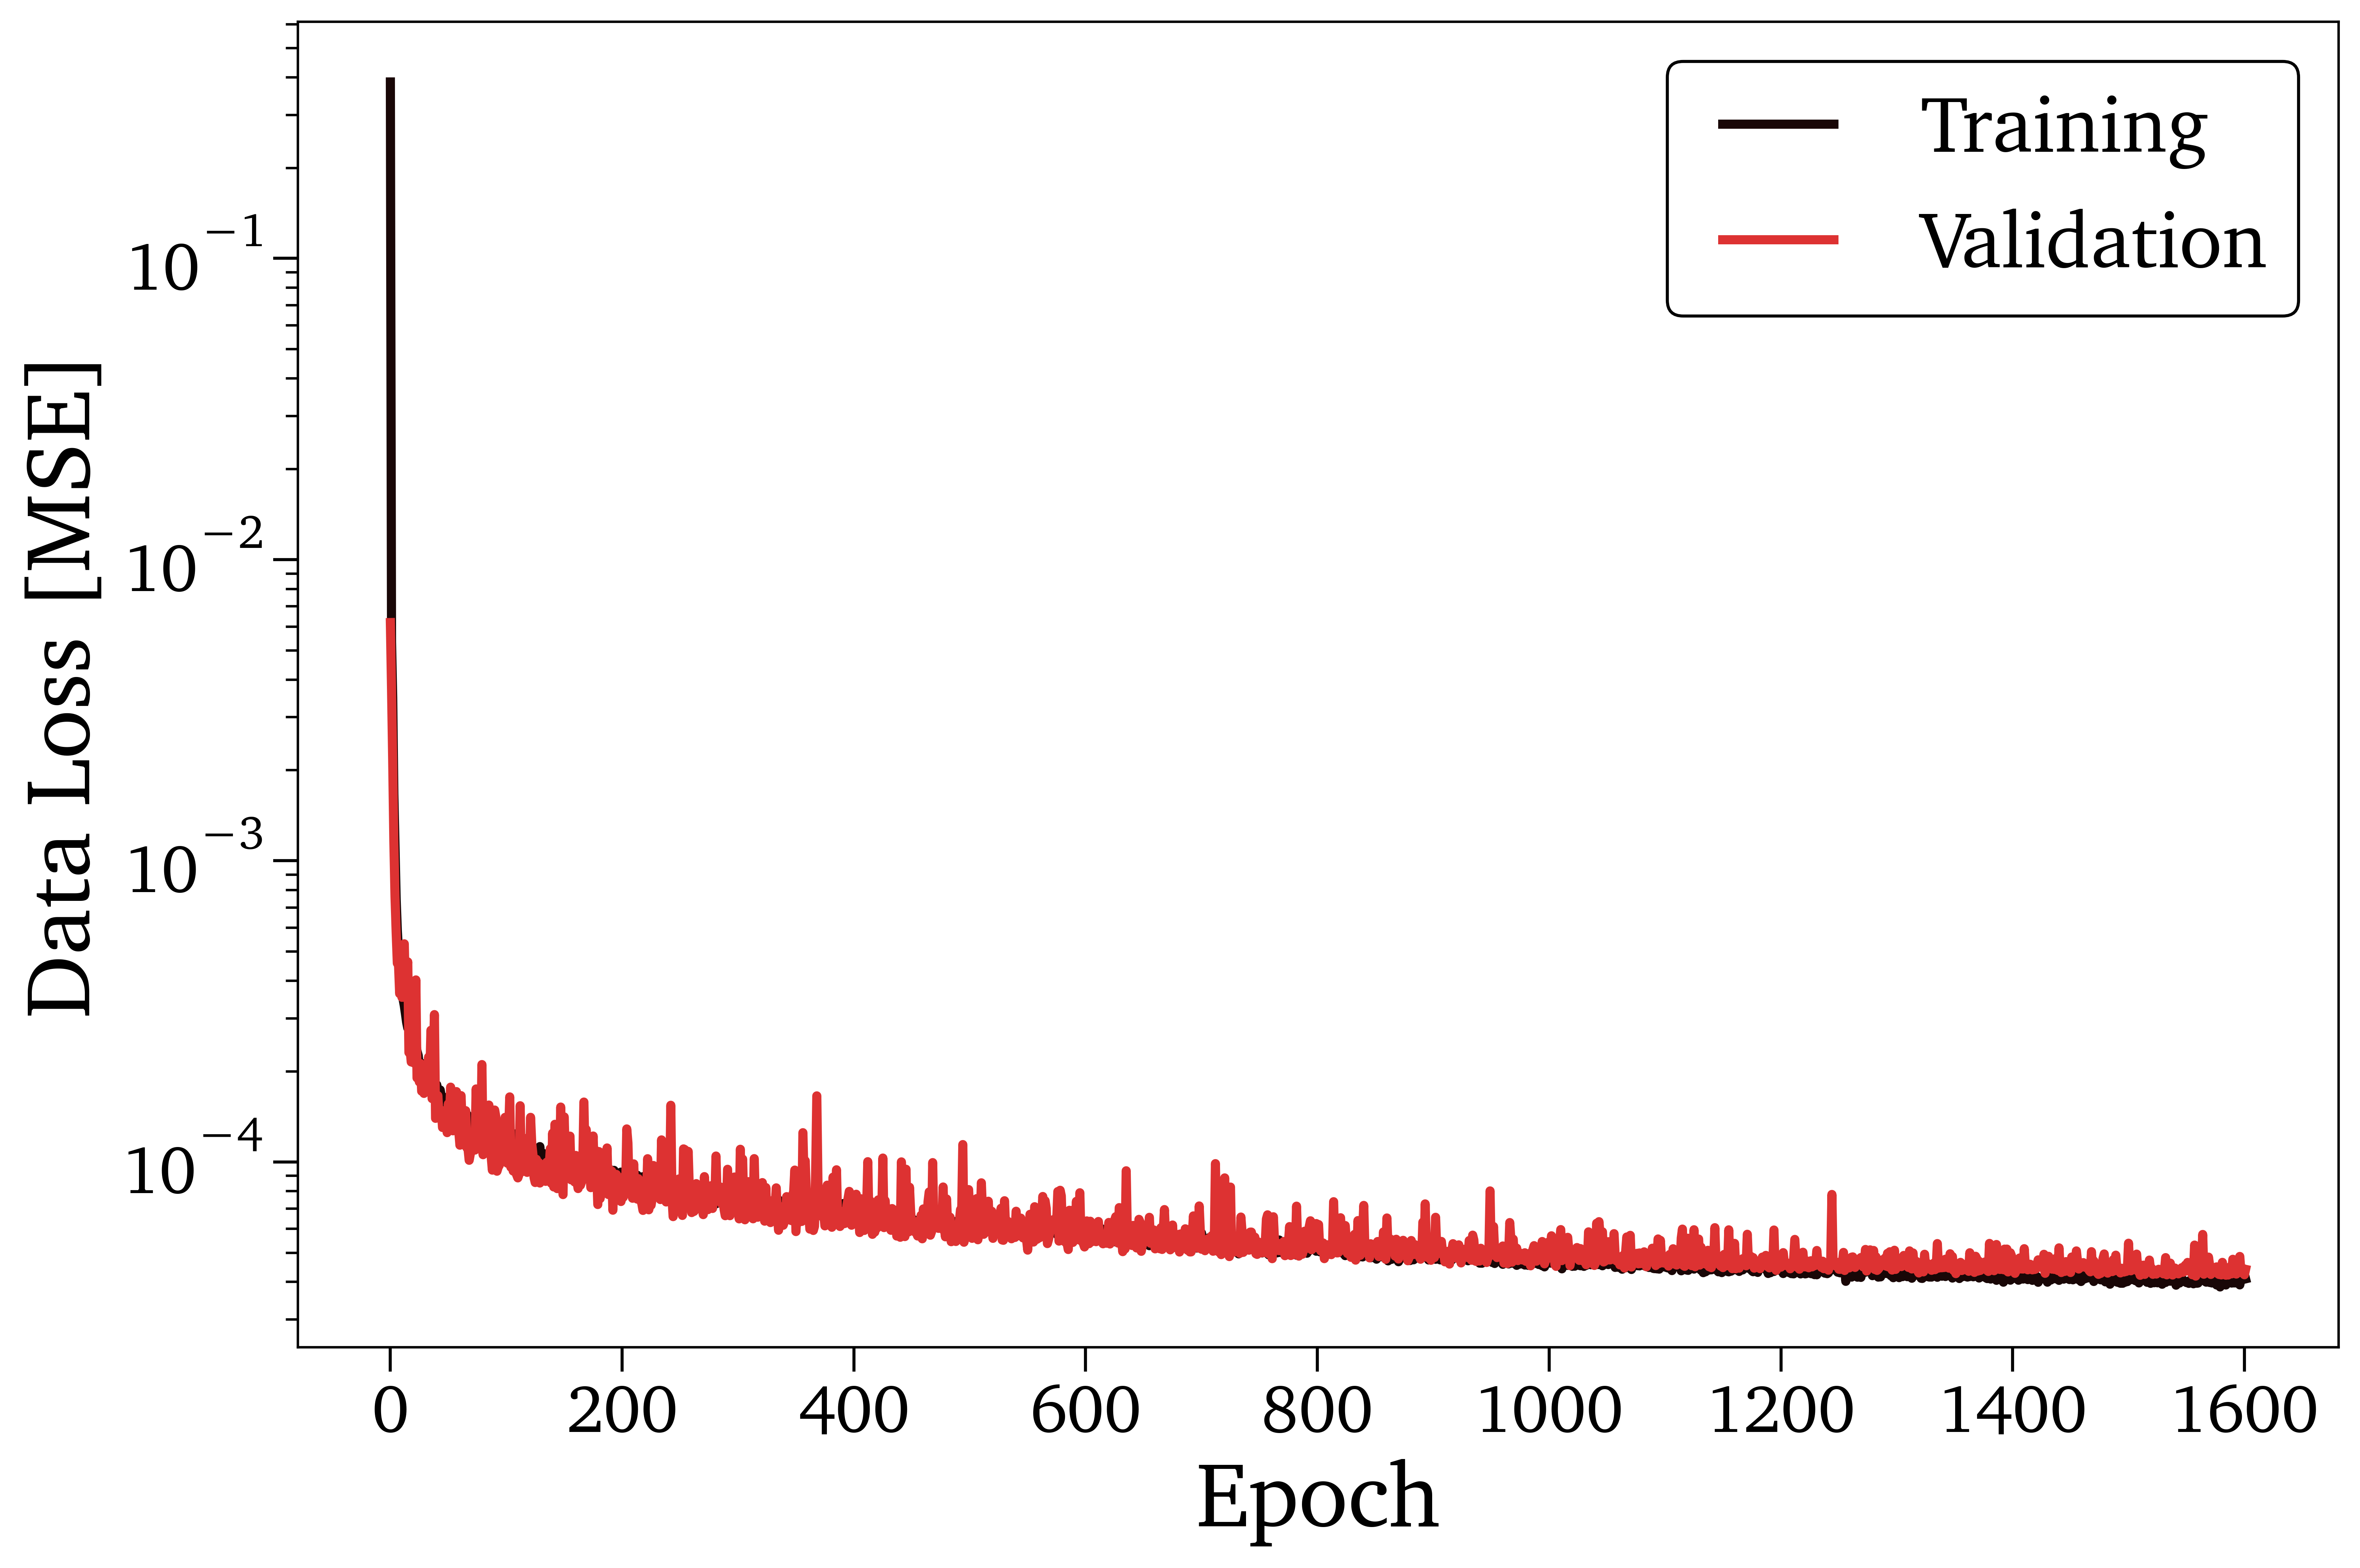

In [23]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Trunk's Outputs

In [ ]:
iTrunk           = 1
iTest            = 0


FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

fig = plt.figure()
plt.plot(Data['t'], Data[Vars[iTrunk]])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\eta_{'+str(iTrunk+1)+'}$')



iVarVec = range(0,6,1)

tVecTot = np.logspace(-14,4,1000)

output_trunk = model.net.system_of_components['MIONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, training=False)

fig = plt.figure()

for iVar in iVarVec:

    plt.plot(tVecTot, output_trunk[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+str(iTrunk+1)+'_{i}}$')

## Evaluating Branches' Outputs

In [ ]:
# FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)


# FileName     = DataDir + '/Orig/train/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics        = len(ICVecs)

Cols   = []
NewFlg = True
for iC in range(n_ics*n_params):

    try:
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iC+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

        DataICTemp       = Data[Vars].iloc[0]

        if (NewFlg):
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))
            
    except:
        pass

tVec              = Data['t']
DataIC            = DataIC.T.drop_duplicates().reset_index(drop=True, inplace=False)

DataIC.head()

DataBranch1       = model.net.layers_dict['MIONet']['Branch1']['MIONet-Branch1_Normalization'](DataIC.to_numpy())

In [ ]:
tVec              = Data['t']
#Data0             = DataIC.T.reset_index(drop=True, inplace=False)
Data0             = ParamsDF

Data0.head()

DataBranch2       = Data0.to_numpy()

In [ ]:
DataAll           = DataIC.merge(Data0, how='cross')
DataBranchAll     = DataAll.to_numpy()

In [ ]:
DataAll

In [ ]:
iBranch = 0
iVar    = 5



output_branch = model.net.system_of_components['MIONet'].components['Branch1_'+str(iBranch+1)].call(DataBranch1, model.net.layers_dict, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['T'], DataIC['H2'], output_branch[:,iVar], c='r')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$H_2$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

In [ ]:
iBranch = 0
iVar    = 5



output_branch = model.net.system_of_components['MIONet'].components['Branch2_'+str(iBranch+1)].call(DataBranch2, model.net.layers_dict, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(Data0['k_1'], Data0['k_2'], output_branch[:,iVar], c='r')
ax.set_xlabel(r'$k_1$')
ax.set_ylabel(r'$k_2$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

## Evaluating Rigid Blocks + Trunk's Outputs

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


output_stretch1 = model.net.system_of_components['MIONet'].components['Stretch1'].call(DataBranch1, model.net.layers_dict, None, training=False)
#output_ = np.log(1. + np.exp(output_))

#for iBranch in range(len(Vars)):
for iBranch in range(2):
    ax.scatter(DataIC['T'], DataIC['H2'], output_stretch1[:,iBranch], label=r'$j='+str(iBranch+1)+'$')
    
    #DF = pd.DataFrame(np.concatenate([DataIC['T'].to_numpy()[...,np.newaxis], DataIC['H2'].to_numpy()[...,np.newaxis], output_[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
    #DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iVar]+'.csv', index=False)

ax.set_xlabel('\n'+r'$T$', rotation = 0)
ax.set_ylabel(r'           $H_2$', rotation = 0)
ax.set_zlabel(r'         $\bar{t}_j$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_MIONet_RigidOutput.eps', format='eps', bbox_inches='tight')

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


output_stretch2 = model.net.system_of_components['MIONet'].components['Stretch2'].call(DataBranch2, model.net.layers_dict, None, training=False)
#output_ = np.log(1. + np.exp(output_))

#for iBranch in range(len(Vars)):
for iBranch in range(2):
    ax.scatter(Data0['k_1'], Data0['k_2'], output_stretch2[:,iBranch], label=r'$j='+str(iBranch+1)+'$')
    
    #DF = pd.DataFrame(np.concatenate([DataIC['T'].to_numpy()[...,np.newaxis], DataIC['H2'].to_numpy()[...,np.newaxis], output_[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
    #DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iVar]+'.csv', index=False)

ax.set_xlabel('\n'+r'$T$', rotation = 0)
ax.set_ylabel(r'           $H_2$', rotation = 0)
ax.set_zlabel(r'         $\bar{t}_j$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_MIONet_RigidOutput.eps', format='eps', bbox_inches='tight')

In [ ]:
# for iBranch in range(len(Vars)):

#     DF = pd.DataFrame(np.concatenate([DataIC['T'].to_numpy()[...,np.newaxis], DataIC['H2'].to_numpy()[...,np.newaxis], output_[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
#     DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iBranch]+'.csv', index=False)

In [ ]:
VarNames=['T',
 'H_{2}',
 'H',
 'O',
 'O_{2}',
 'OH',
 'H_{2}O',
 'HO_{2}',
 'H_{2}O_{2}',
 'N',
 'NH',
 'NH_{2}',
 'NH_{3}',
 'NNH',
 'NO',
 'NO_{2}',
 'N_{2}O',
 'HNO',
 'N_{2}']


fig = plt.figure()

for iBranch in [0,1,2,3,4]:
    plt.scatter(DataIC['T'], output_stretch1[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)
    
plt.xlabel(r'$T_0$')
plt.ylabel(r'$\bar{t}_j^{IC}$')
#plt.yscale('log')
plt.xlim([1000,2000])
#plt.ylim([0,80])

plt.legend(fontsize=30)
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')
    
## np.exp(np.log(1.e-6) - np.log(40))

In [ ]:
fig = plt.figure()

for iBranch in [0,1,2,3]:
    plt.scatter(Data0['k_8'], output_stretch2[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)
    
plt.xlabel(r'$k_2$')
plt.ylabel(r'$\bar{t}_j^{k}$')
#plt.yscale('log')
#plt.ylim([0,80])

plt.legend(fontsize=30)
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')
    
## np.exp(np.log(1.e-6) - np.log(40))

In [ ]:
# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(projection='3d')


# output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), training=False)

# output_.shape

# for iBranch in range(7,14):
#     #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
#     ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


# ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
# ax.set_zlabel(r'$\log(\bar{t})$')
# ax.legend()
# #ax.set_zscale('log')

In [ ]:
iVarVec   = [0,1,2,3,5,9,12]

for iVar in iVarVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iIC in ics_vec:
        for iK in k_vec:
        
            iTest            = iIC * n_params + iK

            FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
            Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

            tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
            yPCA_Data        = Data[Vars].to_numpy()
            Data0            = Data[Data['t'] == 0.][Vars]
    #         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
    #         yPre_Data        = yPCA_Data.dot(A)
    #         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
    #         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

            if NewFlg:
                Label1 = 'ODE'
                Label2 = 'Rigid Block Prepr.'
                NewFlg = False
            else:
                Label1 = None
                Label2 = None


            ax1.plot(tVec, yPCA_Data[:,iVar], color=ColorVec[0], label=Label1)

            ax2.plot(tVec*output_stretch1[iIC,iVar]*output_stretch2[iK,iVar], yPCA_Data[:,iVar], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r'Time [s]', size=34)
    if (Vars[iVar] == 'T'):
        ax1.set_ylabel(r'Temperature [K]', color=color, size=34)
    else:
        ax1.set_ylabel(r'$'+VarNames[iVar]+'$, Mass Fraction', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.set_xlim([1.e-7,1.e-3])

    color = ColorVec[1]
    ax2.set_xlabel(r'      $t/(\bar{t}_j^{IC} \bar{t}_j^{k})$ [s]', color=color, size=34, labelpad=10)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_test_DeepONet_'+Vars[iVar]+'_Shift.eps', format='eps', bbox_inches='tight')

In [ ]:
iVarVec   = [0,1,2,3,5,9,12]

for iVar in iVarVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iIC in ics_vec:
        for iK in k_vec:
        
            iTest            = iIC * n_params + iK

            FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
            Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

            tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
            yPCA_Data        = Data[Vars].to_numpy()
            Data0            = Data[Data['t'] == 0.][Vars]
    #         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
    #         yPre_Data        = yPCA_Data.dot(A)
    #         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
    #         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

            if NewFlg:
                Label1 = 'ODE'
                Label2 = 'Rigid Block Prepr.'
                NewFlg = False
            else:
                Label1 = None
                Label2 = None


            ax1.plot(tVec, yPCA_Data[:,iVar], color=ColorVec[0], label=Label1)

            ax2.plot(tVec*output_stretch1[iIC,iVar], yPCA_Data[:,iVar], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r'Time [s]', size=34)
    if (Vars[iVar] == 'T'):
        ax1.set_ylabel(r'Temperature [K]', color=color, size=34)
    else:
        ax1.set_ylabel(r'$'+VarNames[iVar]+'$, Mass Fraction', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.set_xlim([1.e-7,1.e-3])

    color = ColorVec[1]
    ax2.set_xlabel(r'      $t/(\bar{t}_j^{IC}$ [s]', color=color, size=34, labelpad=10)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_test_DeepONet_'+Vars[iVar]+'_Shift.eps', format='eps', bbox_inches='tight')